In [2]:
import subprocess

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from scipy import stats
import emcee
import numpy as np


%matplotlib inline

## Exercise 1 - Latin Hypercube Design

In [3]:
def generate_lhs(npoints, ndim, seed):
    """
    Generate a maximin Latin-hypercube sample (LHS) with 
    the given number of points, dimensions, and random seed.

    """

    proc = subprocess.run(
        ['R', '--slave'],
        input="""
        library('lhs')
        set.seed({})
        write.table(maximinLHS({}, {}), col.names=FALSE, row.names=FALSE)
        """.format(seed, npoints, ndim).encode(),
        stdout=subprocess.PIPE,
        check=True
    )

    lhs = np.array(
        [l.split() for l in proc.stdout.splitlines()],
        dtype=float
    )


    return lhs


#### Create and plot design matrix below
##### 20 points, 2 dimensions, set the seed to 80

**Exercise**: Fill in the parameters for generate_lhs(), and for plt.scatter

In [212]:
##Fill in the parameters to generate_lhs
design = generate_lhs(npoints = 20,
                      ndim = 2,
                      seed = 80)

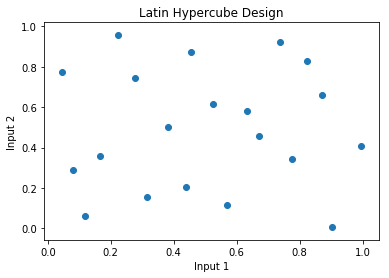

In [213]:
###Fill in parameters to plt.scatter
plt.scatter(x = design[:,0],
           y = design[:,1]) 
plt.title('Latin Hypercube Design')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
pass

## Exercise 2 - Toy GP Example

#### Part a - Mean and Variance Estimate

Run the two cells below

In [808]:
def truth(x):
    return(3*x+np.cos(5*x))
"""
Create 5 design input points equally spaced from -1. to 1.
and evaluate the true function at these design points
"""
design = np.linspace(start=-1.,stop=1.,num=7)
model_data = truth(design)

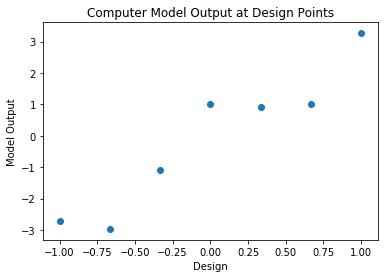

In [809]:
plt.scatter(x=design,y=model_data)
plt.title('Computer Model Output at Design Points')
plt.xlabel('Design')
plt.ylabel('Model Output')
pass

Run the cell below, training the GP

In [814]:
"""
Create a Gaussian process emulator, assuming a two-point function 
with correlation length L,
C(y(x1), y(x2)) = 1/ * exp(-.5 * |x1-x2|^2/L^2 )
"""
L = 2
kernel = (
    1. * kernels.RBF(
        length_scale=L,
        length_scale_bounds=(.1*L, 10*L) 
    ) 
)
gp = GPR(kernel=kernel,
    alpha=1e-2,
    n_restarts_optimizer=10,
    copy_X_train=False).fit(design.reshape(-1,1), model_data)

**Exercise**: Create the vector of points X on which we will predict. X should be a (n x 1) numpy array (you choose n)

    Hint: We only want to predict within the bounds of our design

In [815]:
X = np.linspace(-1,1,101)
X = X.reshape(-1,1)

In [816]:
#This returns the predictive mean and covariance at all the points in X
#mean is a (n,) numpy array, and cov is a (n,n) numpy array
mean, cov = gp.predict(return_cov=True,X=X)

**Exercise**: Fill in the lines for plt.plot, top_var, and bot_var

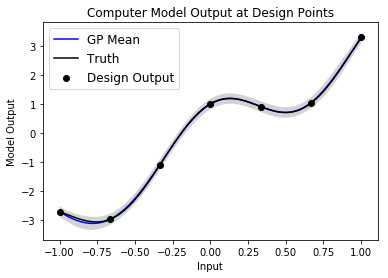

In [817]:
#Set up the figure by first plotting the output at the design points
plt.scatter(x = design,y = model_data,color = 'black',label = 'Design Output', zorder=10)
plt.title('Computer Model Output at Design Points')
plt.xlabel('Input')
plt.ylabel('Model Output')


#Add the mean 95% uncertainty interval of the GP predictions at all the in-between points
##Fill in parameters to plt.plot
##Find expressions for top_var and bot_var
###### Hint: For a normal distribution, how many standard deviations away from the mean is the 97.5% quantile?
###### Hint: Use the diagonal of predictive covariance matrix`
plt.plot( X, mean,color= 'blue',label = 'GP Mean')
top_var = mean + 1.96*np.sqrt(np.diag(cov))
bot_var = mean - 1.96*np.sqrt(np.diag(cov))
plt.fill_between(X[:,0], bot_var, top_var, where=top_var >= bot_var, facecolor='lightgray', interpolate=True)

plt.plot(X,truth(X),color='black',label = 'Truth')
plt.legend(loc='best', fontsize=12)

pass

#### Part b - Random Draws

The prior exercises displayed the mean and variance of our function at all the points in X. But what about actual samples of the function itself? Here we visualize what a random draw of the function would look like.

**Exercse**: Fill in the lines for top_var, bot_var, and rand_draw

    Hint: For rand_draw, examine np.random.multivariate_normal()

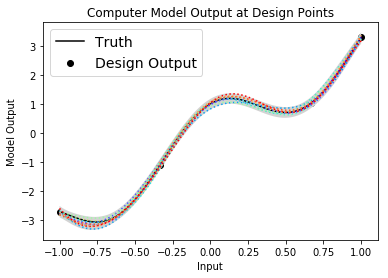

In [818]:
#Get the upper 95% quantile, and lower 95% quantile of the GP predictions at all the in-between points
##Fill in same values as previous exercise
top_var = mean + 1.96*np.sqrt(np.diag(cov))
bot_var = mean - 1.96*np.sqrt(np.diag(cov))

plt.scatter(design,model_data,color = 'black',label = 'Design Output')
plt.title('Computer Model Output at Design Points')
plt.xlabel('Input')
plt.ylabel('Model Output')
plt.fill_between(X[:,0], bot_var, top_var, where=top_var >= bot_var, facecolor='lightgray', interpolate=True)
plt.plot(X,truth(X),color='black',label = 'Truth')

ndraws = 10
colors = cm.rainbow(np.linspace(0, 1, ndraws))

#Get [ndraws] random draws from the predictive distribution of the GP at all of the in-between points 
#Use the predictive mean and covariance
rand_draw = np.random.multivariate_normal(mean,cov,10)
for i in range(ndraws):
    plt.plot(X,rand_draw[i,:],color = colors[i],linestyle = ":")

plt.legend(loc='best', fontsize=14)

pass


## Exercise 3 - Principal Component Analysis

The dataset below contains 20 developmental indices for 132 countries around the world. The country labels (rows) can be found in 'countries.txt,' and the index descriptions can be found in 'indices.txt.' Here we look to explore some of the practical uses of PCA for the purposes of Computer Emulation.

In [142]:
developmental_indices = np.loadtxt('dev_indices.txt')

In [143]:
scaler = StandardScaler(copy=False)
pca = PCA(copy=False, whiten=True, svd_solver='full')
Z = pca.fit_transform(scaler.fit_transform(developmental_indices))

**Exercise**: Plot the cummulative fraction of variance explained. How many PCs would you recommend using?

    Hint: Examine attributes of the object pca, as well as np.cumsum()

In [144]:
F_r = np.cumsum(pca.explained_variance_ratio_)

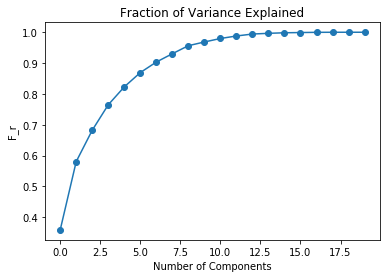

In [145]:
plt.plot(range(len(F_r)),F_r,'-o')
plt.title('Fraction of Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('F_r')
pass

**Exercise**: Find the correlation between the first two principal component vectors

In [146]:
corr = np.correlate(Z[:,0],Z[:,1])
corr

array([3.53050922e-14])

**Exercise**: Plot the second principal component against the first

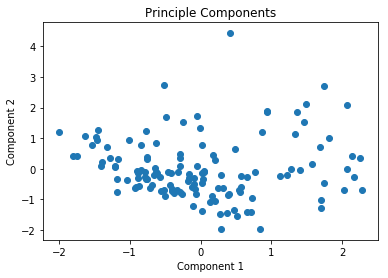

In [147]:
plt.scatter(Z[:,0],Z[:,1])
plt.title('Principle Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
pass

## Exercise 4 - Bayes Rule

Here, we're going to explore the mechanics of Bayesian analysis, and how prior choices can affect the posterior outcome. Let's revisit the coin example from the slides - we flipped 10 coins, and 7 came up heads. Our goal to make inference on the true probability of heads $\theta$, using Bayesian analysis. To do this, we need a likelihood and prior. 






In [148]:
coin_tosses = np.loadtxt('coin_tosses.txt')
num_heads = sum(coin_tosses)
N = len(coin_tosses)

**Likelihood**:
A common model for independent coin flips (or anything with a 0/1 outcome) is Binomial. So our likelihood is Binomial with size N = 10 and probability $\theta$:
\begin{align}
    y\sim \text{Binom}(N,\theta)
\end{align}

The mean of a Binomial random variable $Y$ with size $N$ (flips) and probability $\theta$ (probability of heads) is

\begin{align}
    \mathsf{E}(Y) = N\theta.
\end{align}

The variance of $Y$ is

\begin{align}
    \mathsf{V}(Y) = N\theta(1-\theta)
\end{align}

More information on Binomial distribution can found here: https://en.wikipedia.org/wiki/Binomial_distribution. 


**Prior**:
The most widely used prior for Binomial data and unknown probability is a Beta distribution. A Beta random variable can take value in (0,1).  

\begin{align}
    \theta\sim \text{Beta}(a, b)
\end{align}

The mean of a Beta random variable $\theta$ with first parameter $a$ and second paramter $b$ is

\begin{align}
    \mathsf{E}(\theta) = \frac{a}{a+b}
\end{align}

The variance of $\theta$ is

\begin{align}
    \mathsf{V}(\theta) = \frac{a + b}{(a+b)^2(a+b+1)}
\end{align}

More information on the Beta distribution can found here: https://en.wikipedia.org/wiki/Beta_distribution

Goal: Explore different priors for $\theta$ to see how the posterior of $\theta$ responds. 

#### Method 1: MCMC via python package emcee

Fill in missing pieces to calc_lnprior and calc_lnlike. These functions calculate the log of the prior and likelihood, respectively. For example, for the prior, you need to calculate the log of the pdf at theta for given parameters $a$ and $b$. Use the Wikipedia pages to find the pdfs.

    Hint 1: For the Beta(a,b) prior, you will need to calculate the Beta function of parameters a and b (see the Wikipedia page). The cell below imports betln, which calculates the natural log of the Beta function.

    Hint 2: For the Binomial likelihood, you'll need to calculate 
$$\left(\begin{matrix}N\\y\end{matrix}\right)$$
    
    This is the number of ways to get y heads in N flips. The function nCr(N,y) in the cell below calculates this.


    Hint 3: If done correctly:

    prior_ln_pdf(theta=0.4, a = 2,b = 3) = 0.5470

    likelihood_ln_pdf(theta=0.5,y=num_heads,N=10) = -2.1440
    
    

In [149]:
from scipy.special import betaln
import math

def nCr(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

print(nCr(4,2))

6


In [150]:
#Calculate the log pdf of the prior of theta
def prior_ln_pdf(theta,a,b):
    #Ensure theta is within (0,1)
    if theta <=0 or theta >=1:
        return -np.inf
    
    ######
    ##Add function return
    ######
    return (a-1)*np.log(theta) + (b-1)*np.log(1-theta) - betaln(a,b)

#Calculate the log pdf of the likelihood of y successes (heads) in N trials (flips)
def likelihood_ln_pdf(y, theta, N):
    ######
    ##Add function return
    ######
    return np.log(nCr(N,y)) + y*np.log(theta) + (N-y)*np.log(1-theta)

def posterior_ln_pdf(theta,a,b,y, N):
    ln_pr = prior_ln_pdf(theta=theta,a=a,b=b)
    
    if not np.isfinite(ln_pr):
        return -np.inf
        
    ln_like = likelihood_ln_pdf(y=y, theta=theta,  N = N)
    return ln_pr + ln_like

The code below sets up the sampler. We provide the number of walkers nwalkers (chosen), the number of parameters ndim (1 in our case, since we just have $\theta$), and the posterior function which takes as argument the parameters we're inferrin on. "args" is a tuple of all of arguments to the probability function

In [151]:
a = 1
b = 10

In [152]:
nsamples = 100
nburnin= 50
ndim, nwalkers = 1, 200
sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior_ln_pdf, args=(a, b, num_heads,N))
p0 = np.random.rand(nwalkers,ndim)
out_post = sampler.run_mcmc(p0,nsamples)
samples = sampler.chain[:, nburnin:, :].reshape((-1, ndim))

$nsteps$ is the number of steps each walker will run, while $nburnin$ is the number of "burn-in" or "warmup" steps for each walker.  Our total number of samples will be $nwalkers\times (nsteps-nburnin)$ (recall we want 10,000 total samples). After running each walker for $nsteps$ and discarding the first $nburnin$, we reshape the output chain so each row is a draw from the posterior

In [153]:
nsamples = 100
nburnin= 50
out_post = sampler.run_mcmc(p0,nsamples)
samples = sampler.chain[:, nburnin:, :].reshape((-1, ndim))

Use the samples to find posterior means and variances

In [154]:
#Compare the prior density to the posterior samples
def plot_comparison_mcmc(samples,prior_a, prior_b):
    theta_grid = np.linspace(0.01,0.99,100)
    
    #Calculate the posterior density at the grid of theta values
    prior_pdf_vals = stats.beta(a,b).pdf(theta_grid)
    
    print('Prior mean is')
    print(prior_a/(prior_b+prior_b))
    print('Posterior mean is')
    print(samples.mean())
    
    
    plt.plot(theta_grid,prior_pdf_vals,label = 'Prior Density' )
    plt.hist(samples,normed = True,label = 'Posterior Samples')
    plt.legend(loc='best', fontsize=12)
    pass

**Exercise**: In the above code, change a and b to plot a comparison of the prior density to the histogram of posterior samples for each set of priors. Also report the prior mean versus the mean of the posterior samples

a = 1, b = 1

a = 1, b = 10

a = 10, b = 1

a = 30, b = 30

Prior mean is
0.05
Posterior mean is
0.3898470158972514


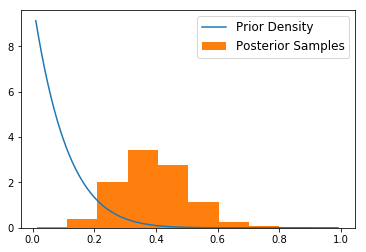

In [155]:
plot_comparison_mcmc(samples,a,b)

#### Method 2: Direct computation of the posterior

We can find the analytics posterior in this case

First, recall the likelihood and prior

\begin{align}
	y\mid\theta&\sim \mathsf{Binom}(N,\theta)\\
	\theta&\sim \mathsf{Beta}(a,b)
\end{align}

Then, we apply Bayes Rule and do a little algebra

\begin{align}
	p(\theta\mid y)&\propto p(y\mid\theta)p(\theta)\\
	 &= \left[\begin{pmatrix}N \\ y\end{pmatrix}\theta^y(1-\theta)^{N-y}\right]\frac{\theta^{a-1}(1-\theta)^{b-1}}{B(a,b)}\\
	 &\propto \theta^{a+y-1}(1-\theta)^{b+N-y-1}
\end{align}
Note that when doing this algebra, we can disregard the constants $\begin{pmatrix}N \\ y\end{pmatrix}$ and $B(a,b)$ because they fall away in the proportionality.

At the end, we recognize the kernel of a $\mathsf{Beta}(a^*,b^*)$ distribution, where
\begin{align}
	a^* &= a + y\\
	b^* &= b + N - y
\end{align}
This is posterior distribution of $\theta$.

Note that this math was very simple only because of the choice of prior and likelihood; a Beta distribution is a so-called "conjugate prior" for a Binomial likelihood. For more comlicated models the posterior will not be available analytically, and we must resort to sampling methods. We only used sampling methods in this model for pedagogical purposes.

**Exercise**: Find the parameters for the posterior distribution of $\theta$ in our model. Compare the prior density to posterior density for the above choices of $a$ and $b$. Do the posterior densities align with the histogram of your posterior samples?

In [156]:
a = 1
b = 10
N = len(coin_tosses)
y = sum(coin_tosses)
a_star = a + y
b_star = b + N -y 

def plot_comparison_analytic(prior_a,prior_b, posterior_a, posterior_b):

    theta_grid = np.linspace(0.01,0.99,100)
    
    #Calculate the prior pdf at the grid of theta values
    prior_pdf_vals = stats.beta(prior_a,prior_b).pdf(theta_grid)
    plt.plot(theta_grid, prior_pdf_vals)
    plt.xlabel('Theta')
    plt.ylabel('Pdf')
    
    #Calculate the posterior pdf at the grid of theta values
    posterior_pdf_vals = stats.beta(posterior_a,posterior_b).pdf(theta_grid)
    plt.plot(theta_grid,posterior_pdf_vals, label = 'Posterior')
    plt.legend(loc='best', fontsize=12)
    pass

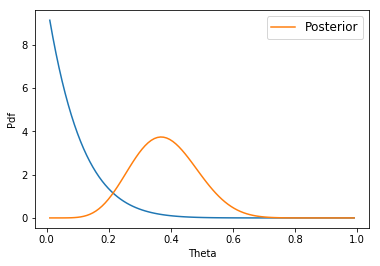

In [157]:
plot_comparison_analytic(a,b,a_star,b_star)

## Exercise 5 - Bayes Rule with a "Toy Jet Quenching" example

\begin{equation}
a = b
\end{equation}
  

In [696]:
from scipy.integrate import quad
from scipy.special import gammaln
np.random.seed(10)
# In this example, we use a very simple model of jet-quenching to practice all the
# all the techniques we learned above:
# Given a measurement: yexp +/- ystat +/- ysys,
#       and a model M : parameters --> predictions
# 1) Make a parameter design on which we run the computer model
# 2) Use Principal Component Analysis (PCA) to do dimension reduction
# 3) Build Gaussian Process emulators (GP) and train on the design
# 4) Construct proir, likelihood and posterior function
# 5) Use MCMC to marginalize the posterior distribution
# 6) Analyse the posterior distribution of the parameters


########### A simple model that calculates a "R_AA" ########################
# Baseline of particle production: dN0/dpT ~ pT/(3^2 + pT^2)^3
@np.vectorize
def dN0_dpT(pT):
    return pT/(3.**2 + pT**2)**3

# The spectrum after energy loss:
@np.vectorize
def dN1_dpT(pT, A, B):
    # dP: The probability of a particle with pT to loose delta_pT
    # Assume: 
    #     1) delta_pT follows a Gamma Distribution
    #     2) mean-pT-loss: <delta_pT> = A*sqrt(pT)
    #     3) pT-loss-fluctuation <delta_pT^2> - <delta_pT>^2 = B*<delta_pT>
    # The two parameters A and B are to be extracted from "data"
    def dP(delta_pT, pT, A, B):
        mean = A*pT**0.5
        std = B*mean
        alpha = mean**2/std**2
        beta = mean/std**2
        x = beta*delta_pT
        return np.exp( (alpha-1.)*np.log(x) - gammaln(alpha) - x ) * beta

    # The spectrum after energy loss is a convolution of dN0/dpT and dP
    # dN1/dpT = [integral] dN0/dpT(pT+Delta_pT) * dP(Delta_pT) * d[Delta_pT]
    def f(ln_1_delta_pT, pT, A, B):
        delta_pT = np.exp(ln_1_delta_pT) - 1.
        return dN0_dpT(pT+delta_pT) * dP(delta_pT, pT+delta_pT, A, B) * (1.+delta_pT)
    result, _, = quad(f, 0.0, np.log(1+10*pT), args=(pT, A, B))
    return result

# "Experimental data"
# Assume the model is perfect, and the truth values of A and B are 1.0 and 0.5
truth = [1., 0.5]
# The Measurement measure the truth Raa, subject to limited statistics and systematic bias
# yexp = y_true + ystat + ysys
# Default: 10% relative statistical uncertainty, ystat=0
@np.vectorize
def Measurement(StatLevel=0.1, SysLevel=0.2):
    pTbin = np.array([1,2,3,4,5,6,10,15,20,30,40,60,100])
    pT = (pTbin[1:] + pTbin[:-1])/2.
    be = (pTbin[1:] - pTbin[:-1])/2.
    y_truth = dN1_dpT(pT, truth[0], truth[1])/dN0_dpT(pT)
    results = y_truth * np.random.normal(1.0, StatLevel, pT.shape[0]) \
              * np.random.normal(1.0, SysLevel)
    return be, pT, y_truth, results, StatLevel*results, SysLevel*y_truth

# The model without known the true value of A and B
# With what we have learned, the probablity distribution of A, B
# will be inferred from data using this model (a perfect model).
@np.vectorize
def Model(pT, A, B):
    return dN1_dpT(pT, A, B)/dN0_dpT(pT)


Text(0,0.5,'$R_{AA}$')

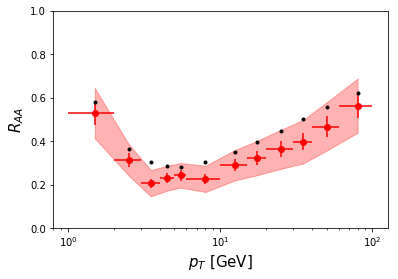

In [697]:
############## Step 1: Get the Measurement #########################
be, pT, ytruth, yexp, ystat, ysys = Measurement()
plt.plot(pT, ytruth, 'k.')
plt.errorbar(pT, yexp, yerr=ystat, xerr=be, fmt='ro')
plt.fill_between(pT, yexp-ysys, yexp+ysys, alpha=0.3, color='r')
plt.ylim(0,1)
plt.semilogx()
plt.xlabel(r'$p_T$ [GeV]', fontsize=15)
plt.ylabel(r'$R_{AA}$', fontsize=15)

Text(0,0.5,'$R_{AA}$')

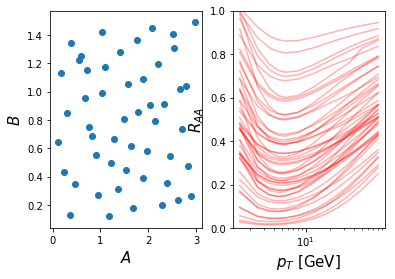

In [698]:
########### Step 2: Make design and generate compuster model prediction on each point ###############
ranges = np.array([[0.1, 3], [0.1, 1.5]])
design = generate_lhs(npoints=50, ndim=2, seed=80)
design[:,:] = (1.-design[:,:])*ranges[:, 0] +  design[:,:]*ranges[:, 1]

# plot all design points
plt.subplot(1,2,1)
plt.scatter(design.T[0], design.T[1])
plt.xlabel("$A$", fontsize=15)
plt.ylabel("$B$", fontsize=15)

# Run model on design points
model_data = np.array([Model(pT, a, b) for (a, b) in design])

# plot all calulations
plt.subplot(1,2,2)
for y in model_data:
    plt.plot(pT, y, 'r-', alpha=0.3)
plt.ylim(0,1)
plt.semilogx()
plt.xlabel(r'$p_T$ [GeV]', fontsize=15)
plt.ylabel(r'$R_{AA}$', fontsize=15)

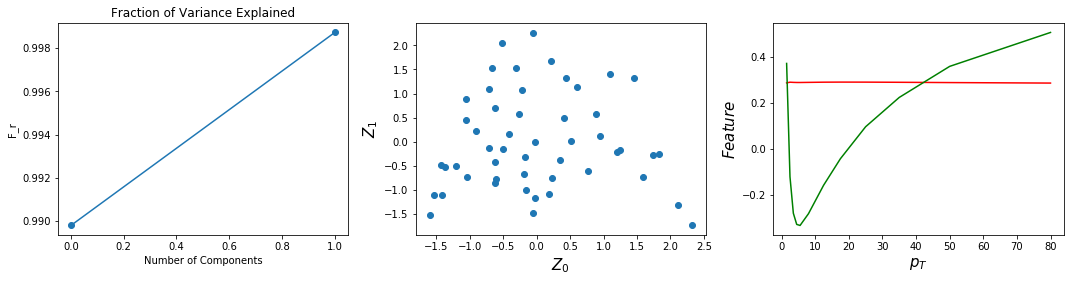

In [699]:
# Step 3: There are too many pT points, apply PCA dimensional reduction
# Keep only the first N principal components
N_truncate = 2
scaler = StandardScaler(copy=True)
pca = PCA(copy=True, whiten=True, n_components=N_truncate, svd_solver='full')
Z = pca.fit_transform(scaler.fit_transform(model_data))

plt.figure(figsize=(15,4))

F_r = np.cumsum(pca.explained_variance_ratio_)
plt.subplot(1,3,1)
plt.plot(range(len(F_r)),F_r,'-o')
plt.title('Fraction of Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('F_r')

plt.subplot(1,3,2)
plt.scatter(Z[:, 0], Z[:, 1])
plt.xlabel('$Z_0$', fontsize=15)
plt.ylabel('$Z_1$', fontsize=15)

plt.subplot(1,3,3)
for comp, color in zip(pca.components_, 'rgbk'):
    plt.plot(pT, comp, color=color)
plt.xlabel('$p_T$', fontsize=15)
plt.ylabel('$Feature$', fontsize=15)

plt.tight_layout(True)

In [700]:
### Step 4-1: Build two emulators for each principal component: Z0 and Z1
# We use a Gaussian kernel plus a white kerenl to account for numerical error of model calculations
kernel = (
    1. * kernels.RBF(
        length_scale=[1.0, 1.0],
        length_scale_bounds=[(.1, 10), (.1, 10)]
    )  
    + kernels.WhiteKernel(.1)
)

# Build and train each GP
gps = [GPR(kernel=kernel, n_restarts_optimizer=10) for i in range(N_truncate)]
for i, gp in enumerate(gps):
    gp.fit(design, Z[:, i])
    print('RBF: ', gp.kernel_.get_params()['k1'])
    print('White: ', gp.kernel_.get_params()['k2'])

RBF:  4.13**2 * RBF(length_scale=[1.56, 1.81])
White:  WhiteKernel(noise_level=1e-05)
RBF:  4.74**2 * RBF(length_scale=[0.793, 0.86])
White:  WhiteKernel(noise_level=1e-05)


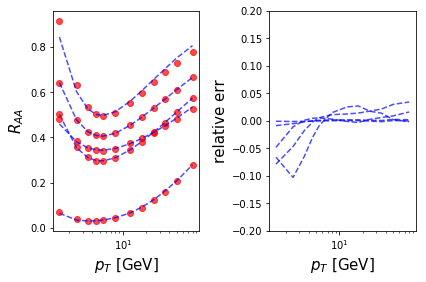

In [701]:
### Step 4-1: It is important to validate the performance of emulators using novel points
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
for (a, b) in [(.5,0.2), (1.4, 0.9), (2.5, 1.4), (2.8, .4), (1.0, 1.0)]:
    # GP prediction
    z = [gp.predict([(a, b)])[0] for gp in gps]
    pred = scaler.inverse_transform(pca.inverse_transform([z]))[0]
    # model calcuatlion
    calc = Model(pT, a, b)
    
    ax1.plot(pT, calc, 'ro', alpha=0.7)
    ax1.plot(pT, pred, 'b--', alpha=0.7)

    ax2.plot(pT, (pred-calc)/calc, 'b--', alpha=0.7)

ax1.semilogx()
ax1.set_xlabel(r'$p_T$ [GeV]', fontsize=15)
ax1.set_ylabel(r'$R_{AA}$', fontsize=15)

ax2.semilogx()
ax2.set_ylim(-.2, .2)
ax2.set_xlabel(r'$p_T$ [GeV]', fontsize=15)
ax2.set_ylabel('relative err', fontsize=15)

plt.tight_layout(True)

In [705]:
# Step 5: Construct the posterior probability distribution function
# Posterior  = prior * likelihood
# ln(Posterior) = ln(prior) + ln(likelihood)
from scipy.linalg import lapack

# A flat prior on the parameters
def prior_ln_pdf(theta):
    if (theta<ranges[:,0]).any() or (theta>ranges[:,1]).any():
        return -np.inf
    else:
        return 0.


# Calculate the likelihood function
# Exp: yexp, ystat, ysys
# Model: prediction from GP at each (a, b)

# calculate dy^T * cov^-1 *dy
def lnLL(dy, cov):
    L, info = lapack.dpotrf(cov, clean=False)
    alpha, info = lapack.dpotrs(L, dy)
    return -.5*np.dot(dy, alpha) - np.log(L.diagonal()).sum()

cov_exp = np.diag(ystat**2) + np.diag(ysys**2)# np.outer(ysys, ysys) # 
O = pca.components_*scaler.scale_
def likelihood_ln_pdf(theta):
    z, stdz = np.array([gp.predict([theta], return_std=True) for gp in gps]).T[0]
    pred = scaler.inverse_transform(pca.inverse_transform([z]))[0]
    cov_emulator = np.matmul(O.T*stdz**2, O)
    return lnLL(pred - yexp, cov_exp + cov_emulator)

# Finally ln(Posterior) = ln(prior) + ln(likelihood)
def posterior_ln_pdf(theta):
    ln_pr = prior_ln_pdf(theta)
    ln_like = likelihood_ln_pdf(theta) 
    return ln_pr + ln_like

In [706]:
# Step 6: Run MCMC
nsamples = 1000
nburnin= 100
ndim, nwalkers = 2, 40
sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior_ln_pdf)
p0 = np.random.rand(nwalkers, ndim)
p0 = (1.-p0)*ranges[:, 0] +  p0*ranges[:, 1]
out_post = sampler.run_mcmc(p0, nsamples)
samples = sampler.chain[:, nburnin:, :].reshape((-1, ndim))

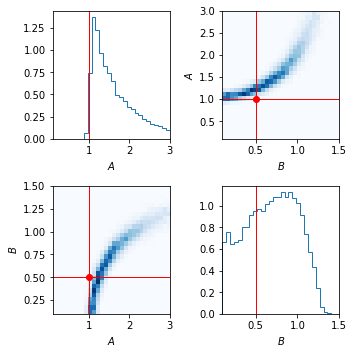

In [707]:
# Step 7: Analysis the posterior probablity distribution
figure, axes = plt.subplots(figsize=(5,5), ncols=ndim, nrows=ndim)
names = [r"$A$", r"$B$"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.hist(samples[:,i], bins=30, range=ranges[i], histtype='step', normed=True)
            ax.set_xlabel(names[i])
            ax.axvline(x=truth[i], color='r', linewidth=1)
            ax.set_xlim(*ranges[j])
        else:
            ax.hist2d(samples[:, j], samples[:, i], bins=30, 
                        range=[ranges[j], ranges[i]], cmap='Blues')
            ax.set_xlabel(names[j])
            ax.set_ylabel(names[i])
            ax.axvline(x=truth[j], color='r', linewidth=1)
            ax.axhline(y=truth[i], color='r', linewidth=1)
            ax.plot(truth[j], truth[i], 'ro')
            ax.set_xlim(*ranges[j])
            ax.set_ylim(*ranges[i])
plt.tight_layout(True)